In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = 'Train/Train/Train'

data_dir = pathlib.Path(DATASET_PATH)


commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'unknown'
 'zero']


In [ ]:
batch_size = 32
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory= data_dir,
    batch_size= batch_size,
    validation_split= 0.2,
    seed= 0,
    output_sequence_length= 16000,
    subset= 'both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Found 17056 files belonging to 11 classes.
Using 13645 files for training.
Using 3411 files for validation.

label names: ['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'unknown'
 'zero']


In [ ]:
# An integer representing the sampling rate.
sr = 16000
# An integer scalar Tensor. The window length in samples.
frame_length = int(sr/40) #25 ms
# An integer scalar Tensor. The number of samples to step.
frame_step = int(sr/100) #10 ms
# An integer scalar Tensor. The size of the FFT to apply.
fft_length = int(sr/40) #25 ms
# An integer representing the num of filterbanks.
num_feats = 40

def get_mfccs(
        audio,
        channels= 1,
        sample_rate= 16000,
        frame_length= 400,
        frame_step = 160,
        fft_length = 400,
        num_feats = 40
    ):

    stfts = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)

    spectrograms = tf.abs(stfts)

    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 0 , sample_rate/2, num_feats
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz, upper_edge_hertz)
    mel_spectrograms = tf.tensordot(
      spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
      linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs from log_mel_spectrograms
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
      log_mel_spectrograms)
    mfccs = mfccs[..., tf.newaxis]

    return mfccs

def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_mfccs(audio, sample_rate=sr, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length, num_feats=num_feats), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_mfcc_ds = make_spec_ds(train_ds)
val_mfcc_ds = make_spec_ds(val_ds)
test_mfcc_ds = make_spec_ds(test_ds)

train_mfcc_ds = train_mfcc_ds.cache().shuffle(len(train_mfcc_ds)*batch_size).prefetch(tf.data.AUTOTUNE)
val_mfcc_ds = val_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mfcc_ds = test_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
def plot_mfcc(mfcc, ax):
  if len(mfcc.shape) > 2:
    assert len(mfcc.shape) == 3
    mfcc = np.squeeze(mfcc, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(mfcc.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(mfcc), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

C:\Users\user\AppData\Local\Temp\ipykernel_10100\3363523240.py:8: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(mfcc.T + np.finfo(float).eps)


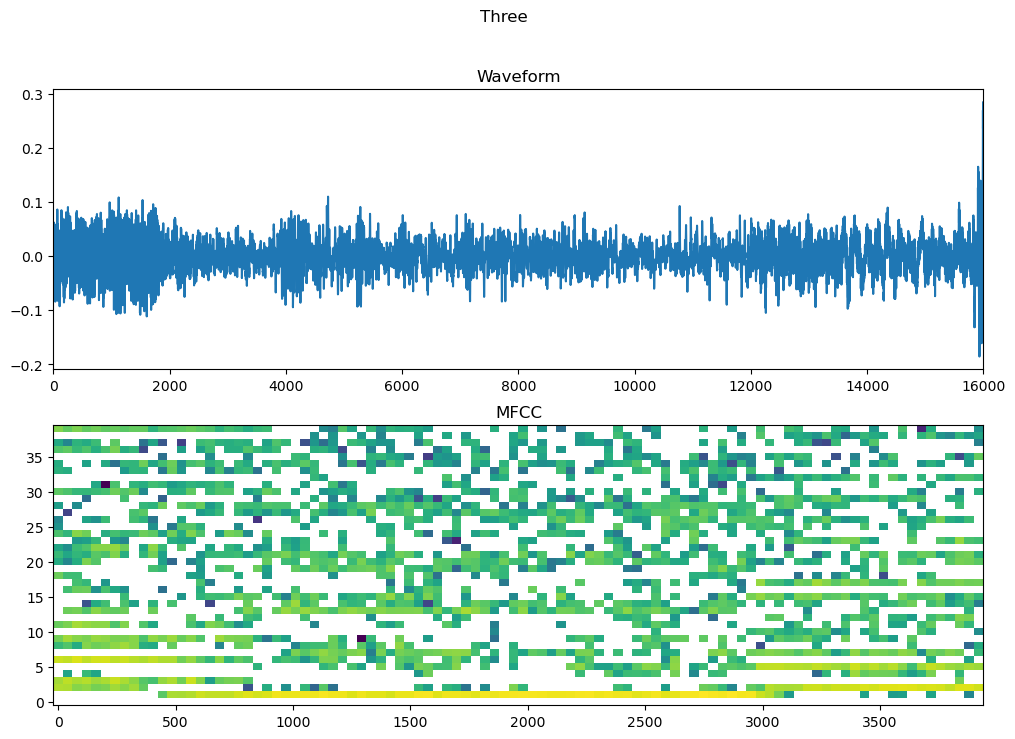

Label: three
Waveform shape: 16000 frames
Waveform duration: 1.0 sec
MFCC expected shape: (98, 40, 1)
MFCC actual shape: (98, 40, 1)
Audio playback


In [ ]:
for example_audio, example_labels in train_ds.take(1):
  label = label_names[example_labels[0]]
  waveform = example_audio[0]
  mfcc = get_mfccs(waveform)

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(waveform.shape[0])
  axes[0].plot(timescale, waveform.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, sr])

  plot_mfcc(mfcc.numpy(), axes[1])
  axes[1].set_title('MFCC')
  plt.suptitle(label.title())
  plt.show()

  print('Label:', label)
  print(f'Waveform shape: {len(waveform)} frames')
  print(f'Waveform duration: {len(waveform) / sr} sec')
  print(f'MFCC expected shape: ({(len(waveform)-fft_length)//frame_step+1}, {num_feats}, 1)')
  print('MFCC actual shape:', mfcc.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=sr))

In [ ]:
for example_mfcc, example_spect_labels in train_mfcc_ds.take(1):
  input_shape = example_mfcc.shape[1:]

num_labels = len(commands)
print(f"Input shape: {input_shape}")
print(f"Num of labels: {num_labels}")

Input shape: (98, 40, 1)
Num of labels: 11


In [ ]:
steps_per_epoch = np.ceil(len(train_mfcc_ds)*batch_size / batch_size)

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1, min_lr=1e-7)

callback = [reduce_lr]

def build_model(input_shape, num_labels):
    x_s = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same')(x_s)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x_e = layers.Dense(num_labels, activation='softmax')(x)
    model = models.Model(inputs=x_s, outputs=x_e)

    # Use the correct argument name for the learning rate
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=strides, padding="same", use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.activation = layers.Activation("relu")
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", use_bias=False)
        self.bn2 = layers.BatchNormalization()

        if strides > 1 or filters != kwargs.get('input_shape', [None, 374, 129, 1])[-1]:  # Ensure skip connection matches dimensions
            self.skip_conv = layers.Conv2D(filters, kernel_size=1, strides=strides, padding="same", use_bias=False)
            self.skip_bn = layers.BatchNormalization()
        else:
            self.skip_conv = None

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        if self.skip_conv is not None:
            skip = self.skip_conv(inputs)
            skip = self.skip_bn(skip, training=training)
        else:
            skip = inputs

        return self.activation(x + skip)

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "strides": self.strides,
        })
        return config

def build_residual_model(input_shape, num_labels):
    x_s = layers.Input(shape=input_shape)

    # Initial Convolution Layer
    x = layers.Conv2D(64, (3, 3), padding='same')(x_s)
    x = layers.MaxPooling2D((2, 2))(x)

    # Adding Residual Units
    for filters in [64, 128, 256]:
        x = ResidualUnit(filters, strides=1)(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x_e = layers.Dense(num_labels, activation='softmax')(x)

    model = models.Model(inputs=x_s, outputs=x_e)

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [ ]:
# Define callbacks (optional)
model = build_residual_model(input_shape, num_labels)
#import h5py
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=55, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)  # Keep .keras extension
]

# Train the model
history = model.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=100,  # Set the number of epochs
    callbacks=callbacks
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 98, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 98, 40, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 49, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 49, 20, 64)     │        78,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 24, 10, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 5, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 12, 5, 256)     │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     3,146,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 11)             │        11,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,388,747 (16.74 MB)

 Trainable params: 4,386,059 (16.73 MB)

 Non-trainable params: 2,688 (10.50 KB)

Epoch 1/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 89s 201ms/step - accuracy: 0.2166 - loss: 3.1313 - val_accuracy: 0.4534 - val_loss: 1.4674
Epoch 2/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 98s 229ms/step - accuracy: 0.4854 - loss: 1.3836 - val_accuracy: 0.5731 - val_loss: 1.2099
Epoch 3/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 101s 236ms/step - accuracy: 0.6087 - loss: 1.0560 - val_accuracy: 0.6097 - val_loss: 1.0546
Epoch 4/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 100s 234ms/step - accuracy: 0.6883 - loss: 0.8439 - val_accuracy: 0.6686 - val_loss: 0.8692
Epoch 5/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 101s 236ms/step - accuracy: 0.7329 - loss: 0.7242 - val_accuracy: 0.7087 - val_loss: 0.7707
Epoch 6/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 104s 243ms/step - accuracy: 0.7898 - loss: 0.6099 - val_accuracy: 0.7217 - val_loss: 0.9088
Epoch 7/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 109s 256ms/step - accuracy: 0.8298 - loss: 0.4871 - val_accuracy: 0.7435 - val_loss: 0.7572
Epoch 8/100
427/427 ━━━━━━━━━━━━━━━━━━━━ 107s 251ms/step - accuracy: 0.

KeyboardInterrupt: 

In [ ]:
import h5py

In [ ]:
model.save('farsi_numbers_detectionjupyter.keras')


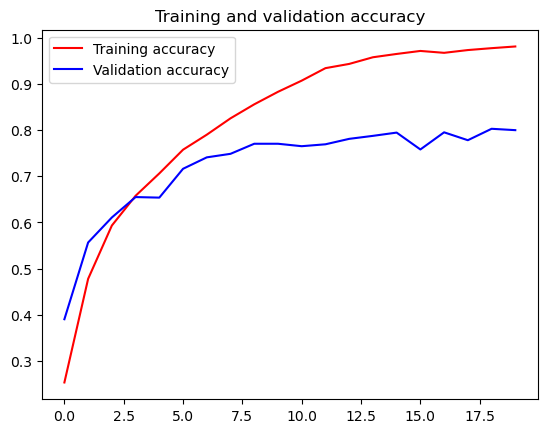

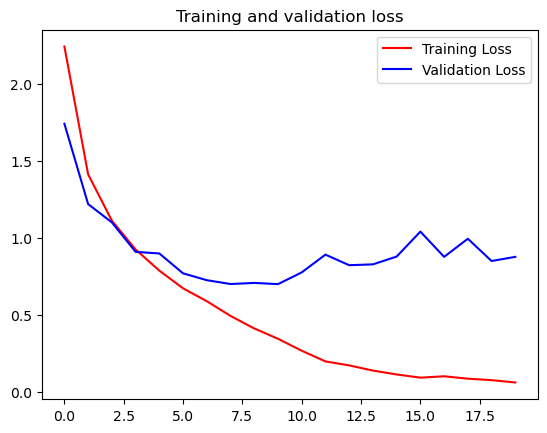

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.clf()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.conv1 = layers.Conv2D(filters, kernel_size=3, strides=strides, padding="same", use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.activation = layers.Activation("relu")
        self.conv2 = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", use_bias=False)
        self.bn2 = layers.BatchNormalization()

        if strides > 1 or filters != kwargs.get('input_shape', [None, 374, 129, 1])[-1]:  # Ensure skip connection matches dimensions
            self.skip_conv = layers.Conv2D(filters, kernel_size=1, strides=strides, padding="same", use_bias=False)
            self.skip_bn = layers.BatchNormalization()
        else:
            self.skip_conv = None

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        if self.skip_conv is not None:
            skip = self.skip_conv(inputs)
            skip = self.skip_bn(skip, training=training)
        else:
            skip = inputs

        return self.activation(x + skip)

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "strides": self.strides,
        })
        return config


In [ ]:
model = tf.keras.models.load_model(
    'farsi_numbers_detectionjupyter.keras',
    custom_objects={'ResidualUnit': ResidualUnit}
)


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'residual_unit', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'residual_unit_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'residual_unit_2', however the

In [ ]:
test_loss, test_acc = model.evaluate(test_mfcc_ds)
print('test_acc:', test_acc, 'test_loss', test_loss)

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8624 - loss: 0.4379
test_acc: 0.8612244725227356 test_loss 0.43501362204551697


In [ ]:
#############################################################################################